# Lecture 21 - Computer Vision

```{contents}
:local:
:depth: 1
```

## Learning goals
- Build and train compact **convolutional neural networks** with PyTorch.
- Track learning curves, compute key metrics, and inspect sample predictions
- Visualize learned filters and intermediate feature maps.

 [![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1VP9tfiiBU8e40iG3qaQlCefkkofVbXiT?usp=sharing) 

Suggested reading for this section: https://poloclub.github.io/cnn-explainer/

## 1. Setup

In [1]:
#pip install torch torchvision torchaudio matplotlib scikit-learn onnx onnxruntime opencv-python tqdm
# 0. setup
import os, random, math, random, requests, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
os.environ["TQDM_DISABLE"] = "1"
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import seaborn as sns
from tqdm.auto import tqdm            # better in notebooks than "from tqdm import tqdm"
SHOW_PBAR = False                     # toggle here

## 2. CNN Model for MNIST

We start with a quick MNIST (Modified National Institute of Standards and Technology database) pipeline to anchor the core ideas. This section fixes random seeds for reproducibility, picks a device, and applies the standard MNIST normalization.

We then load train and test splits, create `DataLoaders`, and show a small gallery to confirm images and labels look correct.

Device: cpu


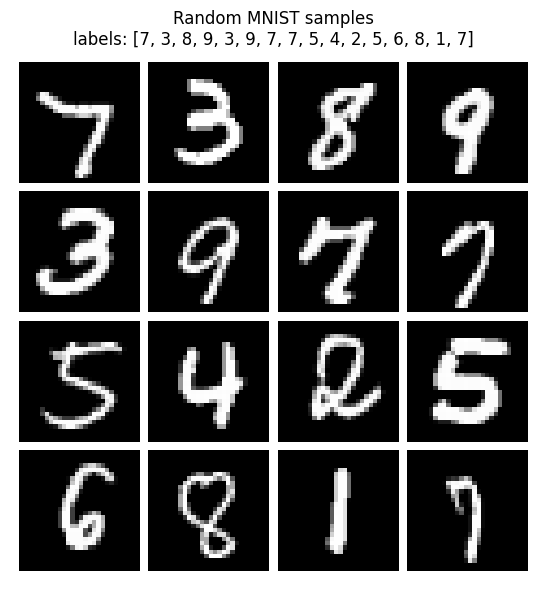

In [2]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transform pipeline:
# 1) convert to tensor in [0,1]
# 2) normalize with MNIST mean and std; helps training stability

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

root = "./data"
train_set = datasets.MNIST(root=root, train=True, download=True, transform=tfm)
test_set  = datasets.MNIST(root=root, train=False, download=True, transform=tfm)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

# Show 16 random samples
def show_samples(ds, n=16, save_path="samples.png"):
    idxs = np.random.choice(len(ds), size=n, replace=False)
    imgs = [ds[i][0] for i in idxs]
    labels = [int(ds[i][1]) for i in idxs]
    grid = vutils.make_grid(torch.stack(imgs), nrow=int(n**0.5), normalize=True, pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.title(f"Random MNIST samples\nlabels: {labels}")
    plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.tight_layout()
    plt.show()            # also writes if you prefer: plt.savefig(save_path)
show_samples(train_set)

Each MNIST image is mostly dark, with a few bright pixels forming the digit.
When all images are combined, their average brightness is about *0.1307*, and how much they vary from that average (the spread) is about *0.3081*.

We use these numbers to normalize every image so the data is centered around zero.

This helps the later CNN train faster and stay stable.

Below, you can see one image before and after normalization.

MNIST mean: 0.1307, std: 0.3081


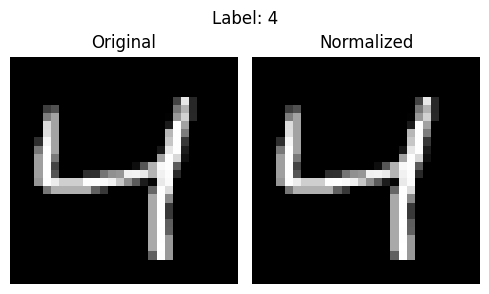

First 20 pixel values (original): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
First 20 pixel values (normalized): [-0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984, -0.42399999499320984]


In [3]:
# Compute MNIST mean and std
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([img for img, _ in mnist])
mean, std = imgs.mean().item(), imgs.std().item()
print(f"MNIST mean: {mean:.4f}, std: {std:.4f}")

# Create raw and normalized datasets
raw_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
norm_ds = datasets.MNIST(root="./data", train=True, download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((mean,), (std,))
                         ]))

# Pick one sample
idx = 2
img_raw, label = raw_ds[idx]
img_norm, _ = norm_ds[idx]

# Convert to numpy
raw_arr = img_raw.squeeze().numpy()
norm_arr = img_norm.squeeze().numpy()

# Show side by side
plt.figure(figsize=(5,3))
plt.subplot(1,2,1); plt.imshow(raw_arr, cmap="gray"); plt.axis("off"); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(norm_arr, cmap="gray"); plt.axis("off"); plt.title("Normalized")
plt.suptitle(f"Label: {label}")
plt.tight_layout(); plt.show()

# Print first 20 pixel values
print("First 20 pixel values (original):", np.round(raw_arr.flatten()[:20], 3).tolist())
print("First 20 pixel values (normalized):", np.round(norm_arr.flatten()[:20], 3).tolist())

Here we define a compact `CNN`: two conv blocks with ReLU and max-pool, then a small MLP head. Dropout helps when the model begins to memorize digits. The spatial path is `28→14→7`, which is why the first linear layer expects `64×7×7` features. The printed parameter count is a quick sanity check that the model is small enough to train in minutes.

In [4]:
# Model development
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First conv block: increase channels from 1 to 32
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # preserves 28x28
        # Second conv block: 32 -> 64 channels
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # preserves 14x14 after pooling
        self.pool = nn.MaxPool2d(2, 2)                # halves width and height
        self.drop = nn.Dropout(0.25)                  # regularization to reduce overfitting
        # After two pools: 28 -> 14 -> 7 so feature map is 64x7x7
        self.fc1  = nn.Linear(64*7*7, 128)            # dense layer for abstraction
        self.fc2  = nn.Linear(128, 10)                # 10 digits

    def forward(self, x):
        # Block 1: conv + ReLU + pool
        x = self.pool(F.relu(self.conv1(x)))          # 1x28x28 -> 32x14x14
        # Block 2: conv + ReLU + pool
        x = self.pool(F.relu(self.conv2(x)))          # 32x14x14 -> 64x7x7
        # Flatten features for linear layers
        x = x.view(x.size(0), -1)
        # Hidden layer with dropout
        x = self.drop(F.relu(self.fc1(x)))
        # Output logits (no softmax here; handled by loss during training)
        return self.fc2(x)

model = Net().to(device)
print("Total parameters:", f"{sum(p.numel() for p in model.parameters()):,}")

Total parameters: 421,642


We train for a few epochs with Adam and cross-entropy. The loop zeros grads, runs forward, computes loss, calls backward, and steps the optimizer. The progress bar reports the latest batch loss, while the epoch average is logged after each pass. If loss is unstable, try a smaller LR such as 1e-3.

In [5]:
epochs = 2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Adam is a good default
criterion = nn.CrossEntropyLoss()                           # expects raw logits and int labels

train_losses, test_losses, test_accs = [], [], []

for epoch in range(1, epochs+1):
    # ---- Training loop ----
    model.train()
    running = 0.0                     # accumulate loss*batch_size for epoch average
    pbar = tqdm(train_loader,
            desc=f"Epoch {epoch}/{epochs} [train]",
            disable=not SHOW_PBAR,    # off when SHOW_PBAR=False
            leave=False,              # do not leave a finished bar on screen
            mininterval=0.5,          # throttles updates
            dynamic_ncols=True)       # adjusts width nicely
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()         # clear previous gradients
        logits = model(x)             # forward pass
        loss = criterion(logits, y)   # compute loss
        loss.backward()               # backpropagate
        optimizer.step()              # update weights
        running += loss.item() * x.size(0)
        pbar.set_postfix(loss=loss.item())

    tr_loss = running / len(train_loader.dataset)
    train_losses.append(tr_loss)

    # ---- Evaluation loop (no grad) ----
    model.eval()                      # eval mode disables dropout
    te_running, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch}/{epochs} [eval]"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            te_running += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()

    te_loss = te_running / len(test_loader.dataset)
    te_acc  = correct / total
    test_losses.append(te_loss); test_accs.append(te_acc)

    print(f"Epoch {epoch}: train loss {tr_loss:.4f}  test loss {te_loss:.4f}  acc {te_acc:.4f}")

C:\Users\52377\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/2 [eval]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: train loss 0.3772  test loss 0.1482  acc 0.9508


Epoch 2/2 [eval]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: train loss 0.2104  test loss 0.1516  acc 0.9519


The above code will take around 3 minutes to run.

Now, With the model in eval mode, we disable gradient work and score the test set. We compute the classification report and confusion matrix to understand both overall and class-wise behavior. Look for classes that dominate errors and for asymmetric confusions, which hint at data or model biases.


Classification report:
              precision    recall  f1-score   support

           0     0.9577    0.9694    0.9635       980
           1     0.9901    0.9648    0.9772      1135
           2     0.9483    0.9593    0.9538      1032
           3     0.8855    0.9723    0.9269      1010
           4     0.9716    0.9745    0.9731       982
           5     0.9745    0.9002    0.9359       892
           6     0.9592    0.9572    0.9582       958
           7     0.9815    0.9300    0.9550      1028
           8     0.9157    0.9261    0.9209       974
           9     0.9434    0.9584    0.9508      1009

    accuracy                         0.9519     10000
   macro avg     0.9527    0.9512    0.9515     10000
weighted avg     0.9530    0.9519    0.9520     10000



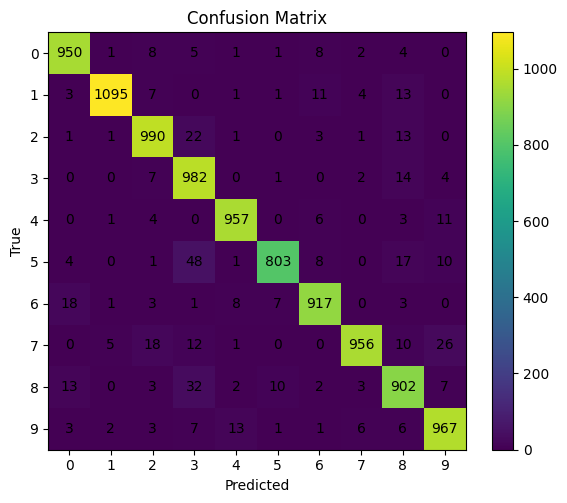

In [6]:
model.eval()
preds, targs = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)                  # only forward needs device here
        logits = model(x)                 # raw scores
        preds.append(logits.argmax(dim=1).cpu().numpy())
        targs.append(y.numpy())

y_pred = np.concatenate(preds)
y_true = np.concatenate(targs)

# Macro and per-class metrics; helpful for imbalanced data and class-wise insight
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix: rows = true, cols = predicted
cm = confusion_matrix(y_true, y_pred)

# Plot with plain matplotlib to show counts
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted"); plt.ylabel("True")

# Write the number in each cell for clarity
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

A quick grid of random test images helps spot obvious failure modes. Correct predictions are green, mistakes are red.

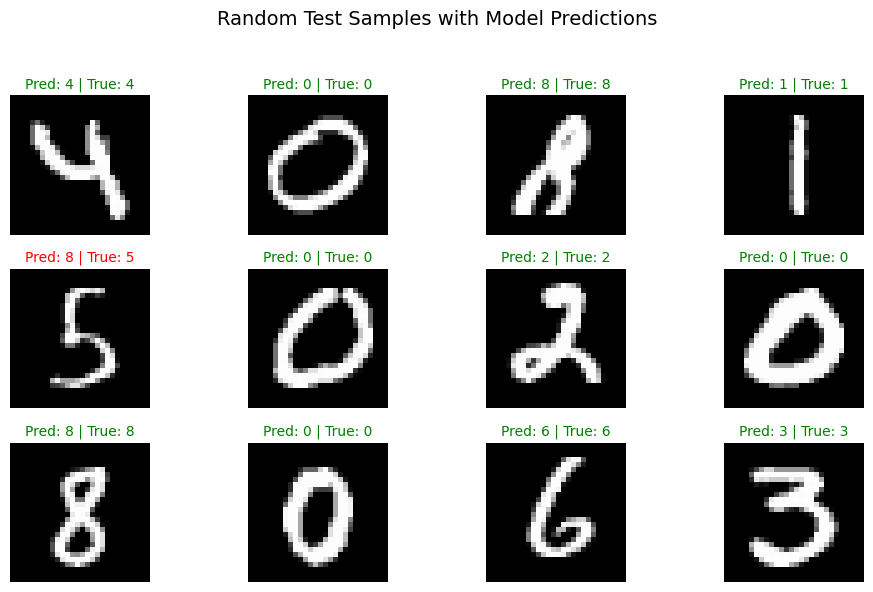

In [7]:
# Show_predictions
import random
random.seed(1)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Switch to eval mode to disable dropout etc.
model.eval()

# Pick 12 random indices from the test set
indices = random.sample(range(len(test_set)), 12)

# Prepare figure
plt.figure(figsize=(10, 6))

for i, idx in enumerate(indices):
    # Get image and ground truth
    img, label = test_set[idx]

    # Model expects batch dimension (N, C, H, W)
    x = img.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(dim=1).item()

    # Convert to numpy for display
    img_np = img.squeeze().numpy()

    # Subplot grid: 3 rows × 4 columns
    plt.subplot(3, 4, i + 1)
    plt.imshow(img_np, cmap="gray")
    # Title includes predicted and true labels
    plt.title(f"Pred: {pred} | True: {label}", color="green" if pred == label else "red", fontsize=10)
    plt.axis("off")

plt.suptitle("Random Test Samples with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 3. Crystal Image Classifier

Next we repeat the workflow on a tiny image folder that contains `crystal` vs `no-crystal` examples.

Small datasets are sensitive to overfitting, so we favor a modest CNN and careful validation. The next cell adds the extra imports used for file I/O, image handling, and plotting.

Below knobs balance speed and accuracy. `IMG_SIZE` controls input resolution. `BATCH_SIZE`, `EPOCHS`, and `LR` shape the training budget. `VAL_RATIO` holds out a slice of data for evaluation when labels are limited.

In [8]:
# setup.
# Imports, config, reproducibility

# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Dataset settings
GITHUB_API_DIR = "https://api.github.com/repos/zzhenglab/ai4chem/contents/book/_data"
DATA_DIR = "./crystal_data/images"     # local cache directory
IMG_SIZE = 200
BATCH_SIZE = 64
VAL_RATIO = 0.2
EPOCHS = 10
LR = 1e-3

Device: cpu


Below we load the image data from Github.
Labels are inferred from filename text such as `crystal_` and `nocrystal_`. The `CrystalFolder` dataset returns `(image, label)` pairs and keeps the interface consistent with torchvision datasets. If you change naming rules, adjust `infer_label`.

We resize, convert to tensor, and normalize to a roughly symmetric range. A quick class count is printed to reveal imbalance that could skew accuracy. We then split into train and test with a fixed seed so results are comparable between runs.

Optionally, we compress the `IMG_SIZE` if needed for faster training.

In [9]:
def download_from_github(out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    print("Listing GitHub folder...")
    r = requests.get(GITHUB_API_DIR, timeout=30)
    r.raise_for_status()
    items = r.json()

    kept = 0
    for it in items:
        if it.get("type") != "file":
            continue
        name = it["name"].lower()
        if not name.endswith((".png", ".jpg", ".jpeg")):
            continue
        url = it["download_url"]
        dst = os.path.join(out_dir, it["name"])
        if os.path.exists(dst):
            kept += 1
            continue
        img = requests.get(url, timeout=60)
        img.raise_for_status()
        with open(dst, "wb") as f:
            f.write(img.content)
        kept += 1
    print(f"Saved {kept} images to {out_dir}")

if not os.path.isdir(DATA_DIR) or len(os.listdir(DATA_DIR)) == 0:
    download_from_github(DATA_DIR)

# Label inference from filename prefix
CLASS_TO_IDX = {"nocrystal": 0, "crystal": 1}

def infer_label(fname: str) -> int:
    f = fname.lower()
    if f.startswith("crystal_"):
        return CLASS_TO_IDX["crystal"]
    if f.startswith("nocrystal_") or f.startswith("no_crystal_"):
        return CLASS_TO_IDX["nocrystal"]
    if "nocrystal" in f or "no_crystal" in f:
        return CLASS_TO_IDX["nocrystal"]
    if "crystal" in f:
        return CLASS_TO_IDX["crystal"]
    raise ValueError(f"Cannot infer label from: {fname}")

class CrystalFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []
        for fn in os.listdir(root):
            if fn.lower().endswith((".png",".jpg",".jpeg")):
                try:
                    y = infer_label(fn)
                    self.samples.append((os.path.join(root, fn), y))
                except ValueError:
                    pass
        self.samples.sort(key=lambda x: x[0])

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, y = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, y

# Transform pipeline:
# 1) resize to <=100
# 2) convert to tensor in [0,1]
# 3) normalize to [-1,1] for training stability
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

full_set = CrystalFolder(DATA_DIR, transform=tfm)

# Print full dataset counts
counts = {0:0, 1:0}
for _, y in full_set.samples: counts[y] += 1
print(f"Total images: {len(full_set)} | no-crystal(0): {counts[0]} | crystal(1): {counts[1]}")

# Split into train and test using the full set
n_test = max(1, int(len(full_set) * VAL_RATIO))
n_train = max(1, len(full_set) - n_test)
train_set, test_set = random_split(
    full_set, [n_train, n_test],
    generator=torch.Generator().manual_seed(42)
)
import platform
on_windows = platform.system() == "Windows"

NUM_WORKERS = 0 if on_windows else 2
PIN_MEMORY  = torch.cuda.is_available()

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=False)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE*4, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=False)

print("Train batches:", len(train_loader), "| Test batches:", len(test_loader))

Total images: 240 | no-crystal(0): 48 | crystal(1): 192
Train batches: 3 | Test batches: 1


Before training, view a small gallery sampled from the full set. Check that images are correctly oriented, labels look right, and normalization did not invert colors. If anything looks off, fix it now to avoid debugging the model later.

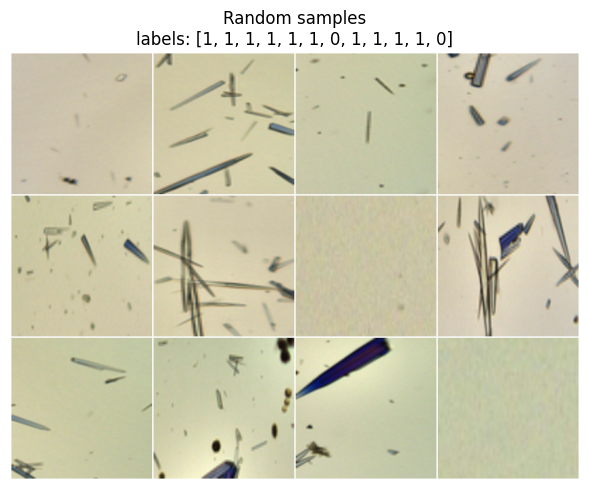

In [10]:
# Show 12 random samples from the full dataset (like your MNIST show)
def show_samples(ds, n=12):
    idxs = np.random.choice(len(ds), size=min(n, len(ds)), replace=False)
    imgs = [ds[i][0] for i in idxs]
    labels = [int(ds[i][1]) for i in idxs]
    grid = vutils.make_grid(torch.stack(imgs), nrow=4, normalize=True, pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.title(f"Random samples\nlabels: {labels}")
    plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.tight_layout()
    plt.show()

show_samples(full_set, n=12)   # 12 representative images at the beginning

Below we build CNN for this task.

Note that this CNN is intentionally compact. Two conv blocks capture local structure, then `AdaptiveAvgPool2d(6,6)` removes the dependency on input size. A small MLP head outputs two logits. The parameter count confirms that the model is light enough for a fast training loop.

In [11]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 3xH x W, any H,W >= 24
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # -> 32xH x W
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # -> 64xH x W
        self.pool  = nn.MaxPool2d(2, 2)               # halves H and W
        # Make the spatial size independent of IMG_SIZE
        self.adapt = nn.AdaptiveAvgPool2d((6, 6))     # -> 64x6x6 regardless of input
        self.drop  = nn.Dropout(0.25)
        self.fc1   = nn.Linear(64*6*6, 128)
        self.fc2   = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))          # 3xHxW -> 32xH/2 x W/2
        x = self.pool(F.relu(self.conv2(x)))          # 32x.. -> 64xH/4 x W/4
        x = self.adapt(x)                              # -> 64x6x6
        x = x.view(x.size(0), -1)                     # 2304
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)

model = SmallCNN().to(device)
print("Parameter count:", f"{sum(p.numel() for p in model.parameters()):,}")

Parameter count: 314,690


The training loop mirrors MNIST. Watch both train and test losses as well as accuracy. On small datasets, a rapid drop in train loss with flat test accuracy is a sign of overfit. If that happens, try stronger augmentation, more dropout, or early stopping.

In [12]:
model = SmallCNN().to(device)
print("Params:", f"{sum(p.numel() for p in model.parameters()):,}")

epochs = EPOCHS
optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # Adam is a good default
criterion = nn.CrossEntropyLoss()                          # expects raw logits and int labels

train_losses, test_losses, test_accs = [], [], []

for epoch in range(1, epochs+1):
    # ---- Training loop ----
    model.train()                      # enable dropout and grads
    running = 0.0                      # accumulate loss*batch_size for epoch avg
    pbar = tqdm(train_loader,
            desc=f"Epoch {epoch}/{epochs} [train]",
            disable=not SHOW_PBAR,    # off when SHOW_PBAR=False
            leave=False,              # do not leave a finished bar on screen
            mininterval=0.5,          # throttles updates
            dynamic_ncols=True)       # adjusts width nicely
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()          # clear previous gradients
        logits = model(x)              # forward pass
        loss = criterion(logits, y)    # compute loss
        loss.backward()                # backpropagate
        optimizer.step()               # update weights
        running += loss.item() * x.size(0)
        pbar.set_postfix(loss=loss.item())

    tr_loss = running / len(train_loader.dataset)
    train_losses.append(tr_loss)

    # ---- Evaluation loop (no grad) ----
    model.eval()                       # eval mode disables dropout
    te_running, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch}/{epochs} [eval]"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            te_running += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()

    te_loss = te_running / len(test_loader.dataset) if len(test_loader.dataset) else 0.0
    te_acc  = correct / total if total else 0.0
    test_losses.append(te_loss); test_accs.append(te_acc)

    print(f"Epoch {epoch}: train loss {tr_loss:.4f}  test loss {te_loss:.4f}  acc {te_acc:.4f}")

Params: 314,690


Epoch 1/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: train loss 0.6470  test loss 0.4585  acc 0.8333


Epoch 2/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2: train loss 0.4758  test loss 0.4384  acc 0.8333


Epoch 3/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3: train loss 0.5089  test loss 0.3948  acc 0.8333


Epoch 4/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4: train loss 0.4550  test loss 0.3889  acc 0.8333


Epoch 5/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5: train loss 0.4169  test loss 0.3354  acc 0.8333


Epoch 6/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6: train loss 0.3801  test loss 0.2832  acc 0.8333


Epoch 7/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7: train loss 0.3312  test loss 0.2406  acc 0.8333


Epoch 8/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8: train loss 0.2799  test loss 0.2017  acc 0.8333


Epoch 9/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9: train loss 0.2406  test loss 0.1687  acc 0.8333


Epoch 10/10 [eval]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10: train loss 0.2068  test loss 0.1444  acc 0.9583


We plot loss and accuracy over epochs to check for convergence and gaps between train and test. The saved `state_dict` in `artifacts/` allows you to reuse the trained weights later without retraining. Keep an eye on file paths if you run from different working directories.

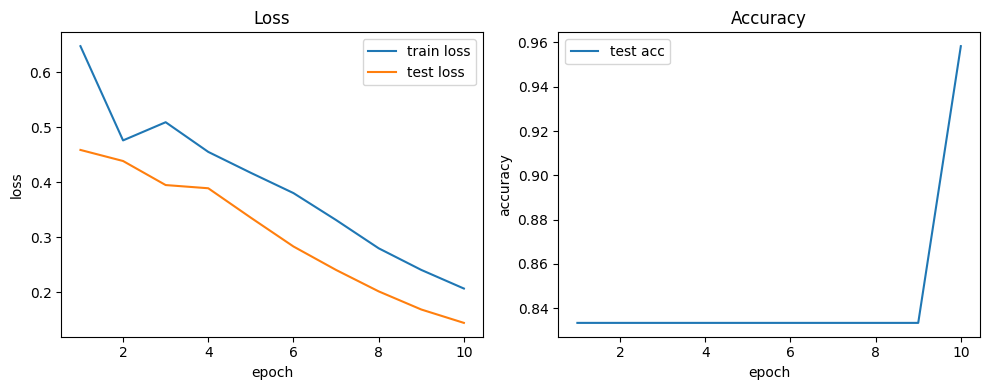

In [13]:
def plot_curves(train_losses, test_losses, test_accs):
    ep = range(1, len(train_losses)+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(ep, train_losses, label="train loss")
    plt.plot(ep, test_losses, label="test loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2)
    plt.plot(ep, test_accs, label="test acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy")
    plt.tight_layout()
    plt.show()

plot_curves(train_losses, test_losses, test_accs)
torch.save(model.state_dict(), "crystal_cnn.pt")

A grid of random test images with predicted and true labels is a fast way to judge errors. Inspect misclassified samples and ask what features might be missing. This often suggests simple fixes such as better normalization or mild augmentation.

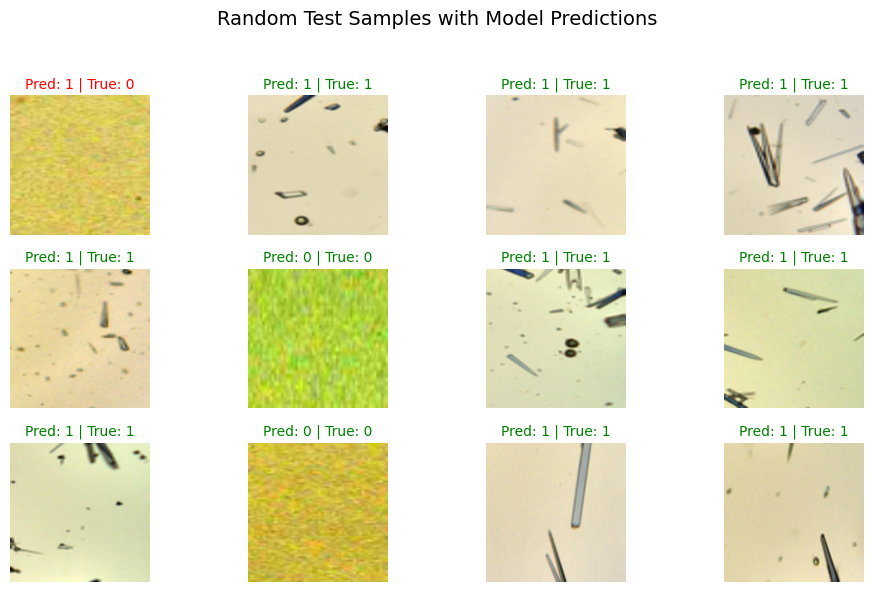

In [14]:
# Show_predictions: 12 random test images with model predictions
random.seed(300)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Switch to eval mode to disable dropout etc.
model.eval()

# Pick 12 random indices from the test set
indices = random.sample(range(len(test_set)), 12)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(indices):
    # Get image and ground truth
    img, label = test_set[idx]

    # Model expects (N, C, H, W)
    x = img.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(dim=1).item()

    # Convert to numpy for display
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)  # normalize to [0,1]

    # 3×4 grid
    plt.subplot(3, 4, i + 1)
    plt.imshow(img_np)
    color = "green" if pred == label else "red"
    plt.title(f"Pred: {pred} | True: {label}", color=color, fontsize=10)
    plt.axis("off")

plt.suptitle("Random Test Samples with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 4. Features the Network Learned

We visualize the first-layer filters after training. Early conv filters often resemble color blobs and edge detectors.

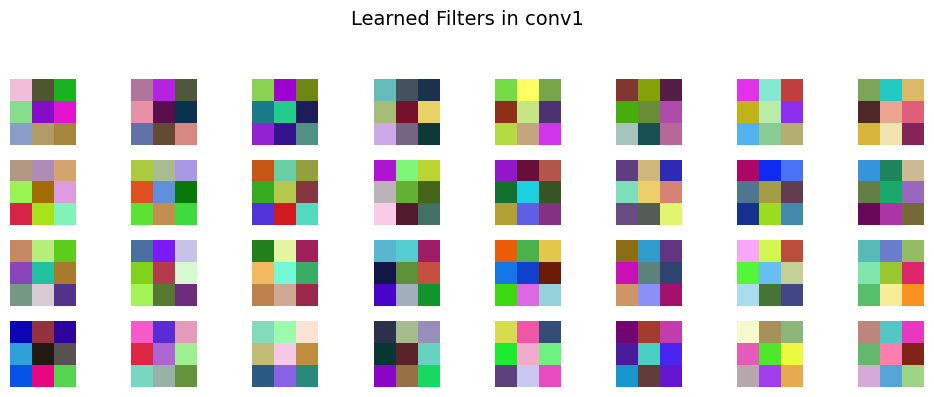

In [15]:
# Access the first conv layer weights
weights = model.conv1.weight.data.clone().cpu()
weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-8)  # normalize to [0,1]

n_filters = min(32, weights.shape[0])
cols = 8
rows = int(np.ceil(n_filters / cols))

plt.figure(figsize=(10, 4))
for i in range(n_filters):
    f = weights[i].permute(1, 2, 0).numpy()
    plt.subplot(rows, cols, i+1)
    plt.imshow(f)
    plt.axis("off")
plt.suptitle("Learned Filters in conv1", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

Feature maps show how the network transforms an input as it moves through the layers. After conv1 you should see edge and texture responses. After conv2 you should see more abstract patterns that correlate with the target classes.

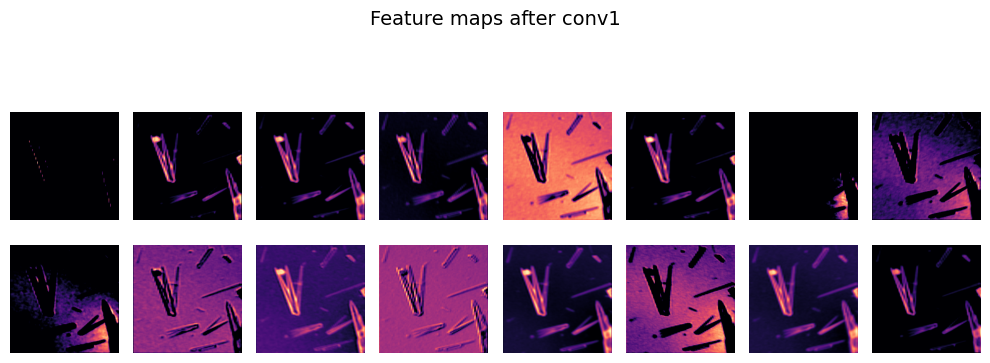

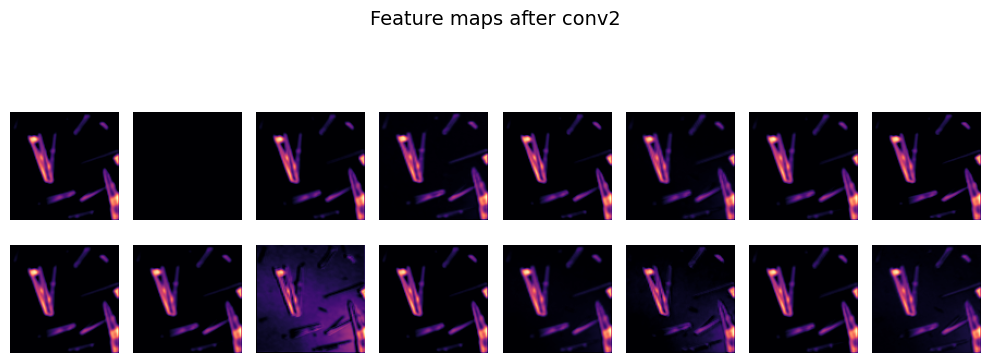

In [16]:
# Visualize feature maps for one test sample
sample_img, _ = test_set[0]
x = sample_img.unsqueeze(0).to(device)

with torch.no_grad():
    act1 = F.relu(model.conv1(x))
    act2 = F.relu(model.conv2(model.pool(act1)))

def show_feature_maps(tensor, title, n=16):
    tensor = tensor.squeeze(0).cpu()
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-8)
    n = min(n, tensor.shape[0])
    cols = 8
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(tensor[i], cmap="magma")
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

show_feature_maps(act1, "Feature maps after conv1")
show_feature_maps(act2, "Feature maps after conv2")

`Grad-CAM` explains a single prediction by weighting channels in a chosen conv layer with gradients of the class score. We hook into `conv2`, collect activations and gradients, then produce a heatmap that we upsample to input size. Bright areas indicate regions the model relied on for that class.

Here we first compute a Grad-CAM map for one test image and overlay it on the original. Compare the heatmap with the predicted class and the ground truth. If the model focuses on background artifacts, revise preprocessing or collect cleaner examples.

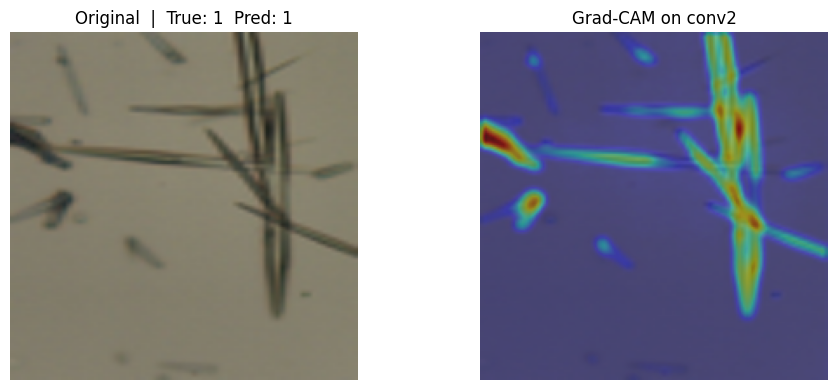

In [17]:
# Detailed Grad-CAM for SmallCNN using conv2 as the target layer

# -----------------------------------------------------------
# Set seeds so your picks are reproducible across runs
# -----------------------------------------------------------
random.seed(0)
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)

# -----------------------------------------------------------
# Grad-CAM helper that attaches forward and backward hooks
# to a target convolutional layer (conv2 here).
# It:
#   1) Runs a forward pass and stores activations from target layer
#   2) Runs a backward pass on the chosen class score and stores grads
#   3) Averages grads over spatial dims for channel weights
#   4) Builds a ReLU-weighted sum of activations to form the CAM
#   5) Upsamples CAM to the input spatial size
# -----------------------------------------------------------
def grad_cam_for_module(model, x, target_module, target_class=None):
    """
    model: your trained SmallCNN
    x:     input tensor of shape (1, C, H, W)
    target_module: the conv module to visualize, e.g., model.conv2
    target_class:  int class index for which to compute Grad-CAM.
                   If None, use the model's predicted class.
    Returns: heatmap as a torch.Tensor of shape (H, W) in [0,1]
    """
    model.eval()

    # Storage for activations and gradients from the target module
    activations = {}
    gradients = {}

    # Forward hook: save feature maps from target module
    def fwd_hook(module, inp, out):
        # out has shape (N, C, H, W). Store detached copy for safety.
        activations["value"] = out.detach()

    # Backward hook: save gradients wrt the feature maps
    # Use register_full_backward_hook to get grad wrt module output
    def bwd_hook(module, grad_in, grad_out):
        # grad_out is a tuple. We want the gradient wrt module output
        gradients["value"] = grad_out[0].detach()

    # Register hooks
    fwd_h = target_module.register_forward_hook(fwd_hook)
    bwd_h = target_module.register_full_backward_hook(bwd_hook)

    # Forward pass
    logits = model(x)                           # (1, num_classes)
    if target_class is None:
        target_class = int(logits.argmax(dim=1).item())
    score = logits[0, target_class]             # scalar

    # Backward pass to get gradients at target layer
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=False)

    # Remove hooks
    fwd_h.remove()
    bwd_h.remove()

    # Pull stored tensors
    A = activations["value"]                    # (1, C, H_l, W_l)
    dA = gradients["value"]                     # (1, C, H_l, W_l)

    # Global average pool the gradients over spatial dimensions to get weights
    # shape: (C, 1, 1)
    weights = dA.mean(dim=(2, 3), keepdim=True)[0]  # (C,1,1)

    # Weighted sum of channels: sum_c w_c * A_c
    # Then apply ReLU as in Grad-CAM paper
    cam = (weights * A[0]).sum(dim=0)           # (H_l, W_l)
    cam = F.relu(cam)

    # Normalize CAM to [0,1]
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    # Upsample CAM from layer size to input size (H, W)
    H, W = x.shape[-2], x.shape[-1]
    cam_up = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(H, W), mode="bilinear", align_corners=False)
    cam_up = cam_up.squeeze(0).squeeze(0)       # (H, W), values in [0,1]
    return cam_up

# -----------------------------------------------------------
# Pick a few test samples and visualize Grad-CAM overlays
# -----------------------------------------------------------
# Expecting you already have: model, device, test_set from previous blocks


# Choose 1 example first
if len(test_set) == 0:
    print("Grad-CAM: test_set is empty. Skipping.")
else:
    idx = 1
    img, label = test_set[idx]                  # img is normalized tensor (C,H,W)
    x = img.unsqueeze(0).to(device)             # add batch dimension

    # Compute predicted class
    with torch.no_grad():
        pred = model(x).argmax(dim=1).item()

    # Build CAM for the predicted class using conv2
    heat = grad_cam_for_module(model, x, target_module=model.conv2, target_class=pred)  # shape (H,W), [0,1]

    # Convert the normalized tensor to a displayable image in [0,1]
    # Undo normalization used in 2_data.py: mean=0.5, std=0.5 -> x = (x-0.5)/0.5
    img_disp = img.clone().permute(1, 2, 0).cpu().numpy()   # H,W,C
    img_disp = (img_disp * 0.5) + 0.5                       # back to [0,1] approx

    # Plot original and CAM overlay
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title(f"Original  |  True: {label}  Pred: {pred}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_disp)
    plt.imshow(heat.cpu().numpy(), cmap="jet", alpha=0.45)  # overlay
    plt.title("Grad-CAM on conv2")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

A small grid of Grad-CAM overlays helps you see consistent attention patterns across many images. Green titles mean correct, red means incorrect. Look for systematic drift such as attention on borders or consistent focus on irrelevant structures.

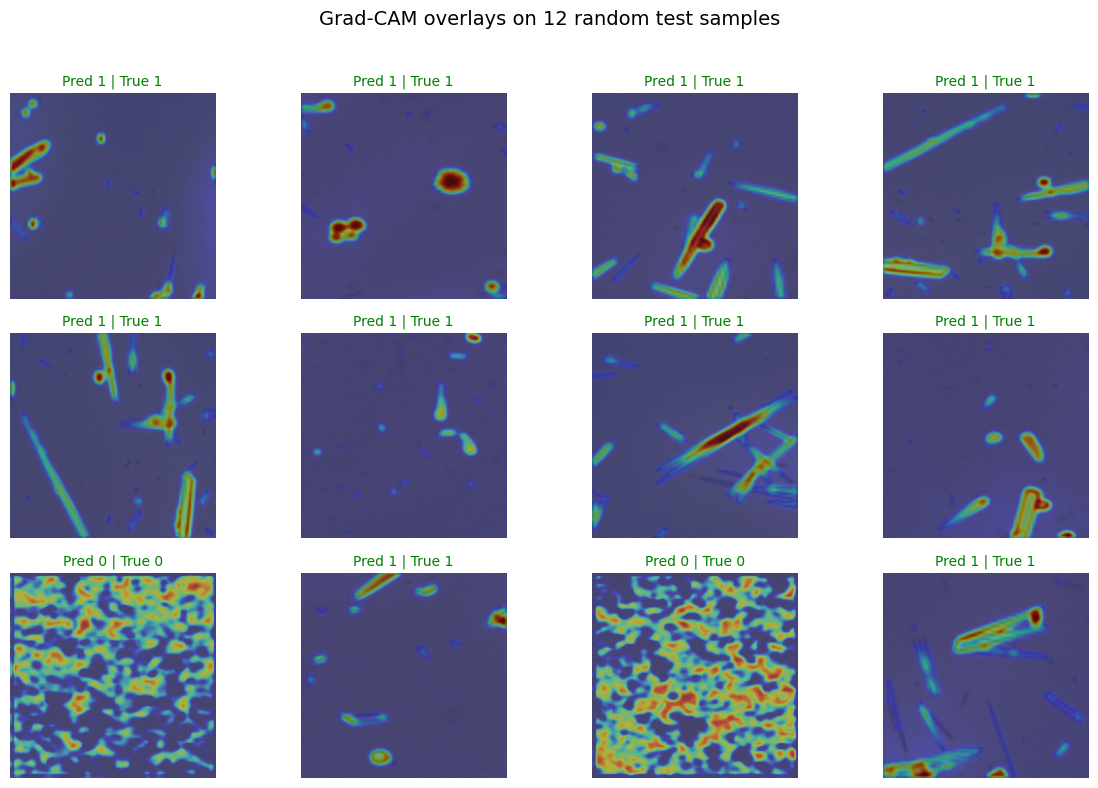

In [18]:
# -----------------------------------------------------------
# grid of 12 Grad-CAM overlays similar to your prediction grid
# -----------------------------------------------------------
def show_gradcam_grid(model, dataset, n=12):
    if len(dataset) == 0:
        print("Dataset empty. Skipping Grad-CAM grid.")
        return
    n = min(n, len(dataset))
    idxs = random.sample(range(len(dataset)), n)

    # Build figure 3x4
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(idxs):
        img, label = dataset[idx]
        x = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x).argmax(dim=1).item()

        heat = grad_cam_for_module(model, x, target_module=model.conv2, target_class=pred)

        # To RGB [0,1]
        img_disp = img.clone().permute(1, 2, 0).cpu().numpy()
        img_disp = (img_disp * 0.5) + 0.5

        plt.subplot(3, 4, i + 1)
        plt.imshow(img_disp)
        plt.imshow(heat.cpu().numpy(), cmap="jet", alpha=0.45)
        color = "green" if pred == label else "red"
        plt.title(f"Pred {pred} | True {label}", color=color, fontsize=10)
        plt.axis("off")
    plt.suptitle("Grad-CAM overlays on 12 random test samples", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the 12-image Grad-CAM grid
show_gradcam_grid(model, test_set, n=12)

## 5. Glossary
```{glossary}

**Channel**
    Depth dimension in a feature map, e.g., 1 for grayscale, 3 for RGB.  
**Convolution (Conv)**
    Sliding filter that extracts spatial patterns.  
**Kernel / Filter**
    Learnable weights used by a conv layer.  
**Padding**
    Zeros added around edges to control output size.  
**Pooling**
    Downsampling operation that reduces spatial size.  
**Feature map** 
    Output tensor of a conv layer.  
**Receptive field**
    Region of the input that influences a unit.  
**Dropout**
    Randomly zeros activations during training to reduce overfit.  
**Logits**
    Raw, unnormalized scores before softmax.  
**Cross-entropy loss**
    Objective for multi-class classification.  
**Grad-CAM**
    Heatmap that highlights image regions that influenced a class score.  
**Adaptive AvgPool**
    
Pooling that outputs a fixed spatial size regardless of input size.
```